In [1]:
import sys

print(sys.executable)


/usr/bin/python3


In [2]:
# !nproc

In [3]:
%pip install --upgrade pip

In [4]:
%pip install opencv-python tqdm matplotlib

In [5]:
# Install dependencies
%pip install torch numpy torchvision

In [6]:
# Import libraries
# import mido
import subprocess
import os
import sys
from os import mkdir
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from music21 import converter
# from pdf2image import convert_from_path
# from google.colab import files
import shutil
import numpy as np
# import cv2
import datetime

In [7]:
!rm -r ai_playing_music

In [8]:
!git clone https://github.com/MichalMiszcz/ai_playing_music.git

Cloning into 'ai_playing_music'...
remote: Enumerating objects: 95511, done.
remote: Counting objects: 100% (6080/6080), done.
remote: Compressing objects: 100% (2787/2787), done.
remote: Total 95511 (delta 2215), reused 6008 (delta 2154), pack-reused 89431 (from 1)
Receiving objects: 100% (95511/95511), 1.61 GiB | 17.96 MiB/s, done.
Resolving deltas: 100% (22125/22125), done.
Updating files: 100% (46976/46976), done.


In [9]:
# %cd /content/ai_playing_music
# !git pull

In [10]:
global count_tracks
count_tracks = 0

In [11]:
HEIGHT = 416
WIDTH = 608

WHITE_KEYS_MIDI = [60, 62, 64, 65, 67, 69, 71, 72]
NUM_NOTES = len(WHITE_KEYS_MIDI)

VELOCITY = [0, 90]
NUM_VELOCITIES = len(VELOCITY)

DELTA_TIME = [0, 5040, 10080, 20160, 30240, 40320]
NUM_DELTA_TIME = len(DELTA_TIME)

# AutoEncoder model

## Enkoder

In [12]:
from typing import Callable, List, Optional, Type

import torch.nn as nn
from torch import Tensor

"""From https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html#resnet18"""

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlockEnc(nn.Module):
    """The basic block architecture of resnet-18 network.
    """
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out



class Encoder(nn.Module):
    """The encoder model.
    """
    def __init__(
        self,
        block: Type[BasicBlockEnc],
        layers: List[int],
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlockEnc) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[BasicBlockEnc],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

## Dekoder

In [13]:
from typing import Callable, List, Optional, Type

import torch.nn as nn
from torch import Tensor


"""Based on https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html#resnet18"""


def conv3x3Transposed(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1, output_padding: int = 0) -> nn.Conv2d:
    """3x3 convolution with padding
    """
    return nn.ConvTranspose2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        output_padding = output_padding, # output_padding is neccessary to invert conv2d with stride > 1
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1Transposed(in_planes: int, out_planes: int, stride: int = 1, output_padding: int = 0) -> nn.Conv2d:
    """1x1 convolution
    """
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False, output_padding = output_padding)


class BasicBlockDec(nn.Module):
    """The basic block architecture of resnet-18 network.
    """
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        output_padding: int = 0,
        upsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3Transposed(planes, inplanes, stride, output_padding=output_padding)
        self.bn1 = norm_layer(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3Transposed(planes, planes)
        self.bn2 = norm_layer(planes)
        self.upsample = upsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv2(x)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv1(out)
        out = self.bn1(out)

        if self.upsample is not None:
            identity = self.upsample(x)

        out += identity
        out = self.relu(out)
        return out





class Decoder(nn.Module):
    """The decoder model.
    """
    def __init__(
        self,
        block: Type[BasicBlockDec],
        layers: List[int],
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64 # change from 2048 to 64. It should be the shape of the output image chanel.
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        self.de_conv1 = nn.ConvTranspose2d(self.inplanes, 1, kernel_size=7, stride=2, padding=3, bias=False, output_padding=1)
        self.bn1 = norm_layer(1)
        self.relu = nn.ReLU(inplace=True)
        self.unpool = nn.Upsample(scale_factor=2, mode='bilinear') # NOTE: invert max pooling

        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1 ,output_padding = 0, last_block_dim=64)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlockDec) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[BasicBlockDec],
        planes: int,
        blocks: int,
        stride: int = 2,
        output_padding: int = 1, # NOTE: output_padding will correct the dimensions of inverting conv2d with stride > 1.
        # More info:https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
        last_block_dim: int = 0,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        upsample = None
        previous_dilation = self.dilation

        layers = []

        self.inplanes = planes * block.expansion

        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        if last_block_dim == 0:
            last_block_dim = self.inplanes//2

        if stride != 1 or self.inplanes != planes * block.expansion:
            upsample = nn.Sequential(
                conv1x1Transposed(planes * block.expansion, last_block_dim, stride, output_padding),
                norm_layer(last_block_dim),
            )

        layers.append( block(
                last_block_dim, planes, stride, output_padding, upsample, self.groups, self.base_width, previous_dilation, norm_layer
            ))
        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)

        x = self.unpool(x)
        x = self.de_conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        return x


    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

## Autoenkoder

In [14]:
import torch.nn as nn

class AE(nn.Module):
    """Construction of resnet autoencoder.

    Attributes:
        network (str): the architectural type of the network. There are 2 choices:
            - 'default' (default), related with the original resnet-18 architecture
            - 'light', a samller network implementation of resnet-18 for smaller input images.
        num_layers (int): the number of layers to be created. Implemented for 18 layers (default) for both types
            of network, 34 layers for default only network and 20 layers for light network.
    """

    def __init__(self, network='default', num_layers=18):
        """Initialize the autoencoder.

        Args:
            network (str): a flag to efine the network version. Choices ['default' (default), 'light'].
             num_layers (int): the number of layers to be created. Choices [18 (default), 34 (only for
                'default' network), 20 (only for 'light' network).
        """
        super().__init__()
        self.network = network
        if self.network == 'default':
            if num_layers==18:
                # resnet 18 encoder
                self.encoder = Encoder(BasicBlockEnc, [2, 2, 2, 2])
                # resnet 18 decoder
                self.decoder = Decoder(BasicBlockDec, [2, 2, 2, 2])
            elif num_layers==34:
                # resnet 34 encoder
                self.encoder = Encoder(BasicBlockEnc, [3, 4, 6, 3])
                # resnet 34 decoder
                self.decoder = Decoder(BasicBlockDec, [3, 4, 6, 3])
            else:
                raise NotImplementedError("Only resnet 18 & 34 autoencoder have been implemented for images size >= 64x64.")
        else:
                raise NotImplementedError("Only default and light resnet have been implemented. Th light version corresponds to input datasets with size less than 64x64.")

    def forward(self, x):
        """The forward functon of the model.

        Args:
            x (torch.tensor): the batched input data

        Returns:
            x (torch.tensor): encoder result
            z (torch.tensor): decoder result
        """
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z


# Music Image Dataset

In [31]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import random
import cv2
# import mido

note_to_index = {midi_num: i for i, midi_num in enumerate(WHITE_KEYS_MIDI)}
velocity_to_index = {midi_num: i for i, midi_num in enumerate(VELOCITY)}
delta_time_to_index = {midi_num: i for i, midi_num in enumerate(DELTA_TIME)}

class MusicImageDataset(Dataset):
    def __init__(self, image_root, midi_root, image_transform=None, max_seq_len=100, max_midi_files=100, modify_image=False):
        self.image_root = image_root
        self.midi_root = midi_root
        self.image_transform = image_transform if image_transform else transforms.ToTensor()
        self.max_seq_len = max_seq_len
        self.modify_image = modify_image
        self.targets = np.arange(0, max_midi_files)

        midi_files = []
        for root, dirs, files in os.walk(midi_root):
            folder = os.path.basename(os.path.dirname(root))
            author = os.path.basename(root)
            for file in files:
                if file.endswith('.mid'):
                    midi_files.append((folder, author, os.path.join(root, file)))

        random.shuffle(midi_files)
        sorted_midi_files = sorted(midi_files[:max_midi_files], key=lambda x: x[2])
        self.selected_midi_files = sorted_midi_files

        self.image_paths = []
        self.midi_features = {}
        records_to_remove = []

        for folder, author, midi_file in self.selected_midi_files:
            folder = os.path.splitext(os.path.basename(midi_file))[0]
            file = os.path.splitext(os.path.basename(midi_file))[0] + "-1" # Added only for my files
            image_dir = os.path.join(image_root, author, folder)

            if os.path.exists(image_dir):
                image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg'))]
                for file in image_files:
                    self.image_paths.append(os.path.join(image_dir, file))

        self.image_paths.sort()
        print(f"Selected {len(self.image_paths)} images.")

        if len(self.image_paths) == 0:
            raise ValueError("No images found for the selected MIDI files. Check directory paths and file structure.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        rel_path = os.path.relpath(img_path, self.image_root)
        composer, piece, _ = rel_path.split(os.sep)
        midi_key = f"{composer}/{piece}"

        image = Image.open(img_path).convert('L')

        apply_augmentation = random.randrange(0, 1)
        # if apply_augmentation <= self.aug_prob:
        #     if self.modify_image:
        #         img_array = np.array(image)
        #         # angle = random.uniform(-2, 2)
        #         angle = 0
        #         x_shift = random.randint(-10, 10)
        #         y_shift = random.randint(0, 30)

        #         rotated_array = modify_image_opencv(img_array, angle, x_shift, y_shift)

        #         image = Image.fromarray(rotated_array)

        if self.image_transform:
            image = self.image_transform(image)

        return image


    def modify_image_opencv(image_array, angle, x_shift, y_shift):
        (h, w) = image_array.shape[:2]
        center = (w // 2, h // 2)

        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

        matrix[0, 2] += x_shift
        matrix[1, 2] += y_shift

        rotated = cv2.warpAffine(image_array, matrix, (w, h), borderValue=(255, 255, 255))
        return rotated

#Uczenie

In [52]:
from tqdm import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt
import os


def train_epoch(cae, device, dataloader, loss_fn, optimizer):
    """The training loop of autoencoder.

    Args:
        cae (classes.resnet_autoencoder.AE): the autoencoder model with - by default- random initilized weights.
        device (str): if exists, the accelarator device used from the machine and supported from the pytorch else cpu.
        dataloader (DataLoader): loader with the training data.
        loss_fn (torch.nn.modules.loss): the loss function of the autoencoder
        optimizer (torch.optim): the optimizer of the autoencoder

    Returns:
        (float): the mean of training loss
    """
    # Set train mode for both the encoder and the decoder
    cae.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for _, x_batch in enumerate(dataloader):
        # Move tensor to the proper device
        x_batch = x_batch.to(device)
        # CAE data
        decoded_batch,_ = cae(x_batch)
        # Evaluate loss
        loss = loss_fn(decoded_batch, x_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


def test_epoch(cae, device, dataloader, loss_fn):
    """The validation loop of autoencoder on the test dataset.

    Args:
        cae (classes.resnet_autoencoder.AE): the autoencoder model.
        device (str): if exists, the accelarator device used from the machine and supported from the pytorch else cpu.
        dataloader (DataLoader): loader with the test data.
        loss_fn (torch.nn.modules.loss): the loss function of the autoencoder.

    Returns:
        (float): the validation loss.
    """
    # Set evaluation mode for encoder and decoder
    cae.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        decoded_data = []
        original_data = []
        for _, x_batch in enumerate(dataloader):
            # Move tensor to the proper device
            x_batch = x_batch.to(device)
            # CAE data
            decoded_batch,_ = cae(x_batch)
            # Append the network output and the original image to the lists
            decoded_data.append(decoded_batch.cpu())
            original_data.append(x_batch.cpu())
        # Create a single tensor with all the values in the lists
        decoded_data = torch.cat(decoded_data)
        original_data = torch.cat(original_data)
        # Evaluate global loss
        val_loss = loss_fn(decoded_data, original_data)

    return val_loss.data


def plot_ae_outputs(cae, dataset_opt, epoch, dataset, device, n=10):
    """Saving plot diagrams with reconstructed images in comparision with the original ones for a visual assessment.

    Args:
        cae (classes.resnet_autoencoder.AE): the trained autoencoder model.
        dataset_opt (str): the name on the input dataset. Proposed choices ['train_dataset', 'test_dataset']
        epoch (int): the present epoch in progress.
        device (str): if exists, the accelarator device used from the machine and supported from the pytorch else cpu.
        n (int): the number of original images to be plotted with their reconstructions. 10 (default).
    """
    plt.figure(figsize=(64,32))
    targets = np.array(dataset.targets)

    print("targets: ", targets)

    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}

    print("t_idx: ", t_idx)

    for i in range(n):

        ax = plt.subplot(2,n,i+1)
        img = dataset[t_idx[i]][0] # dataset[t_idx[i]]-> tuple (X,Y)

        print(img.dim())

        plt.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Original images from ' + dataset_opt + ' epoch=' + str(epoch))

        ax = plt.subplot(2, n, i + 1 + n)
        img = img.unsqueeze(0).to(device) # img -> (3, xx, xx) but img.unsqueeze(0) -> (1,3,xx,xx)
        cae.eval()
        with torch.no_grad():
            rec_img, _  = cae(img)

        print(rec_img.dim())

        rec_img = rec_img.cpu().squeeze() # rec_img -> (1, 3, xx, xx) but img.squeeze() -> (3,xx,xx)

        print(rec_img.dim())

        plt.imshow(rec_img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Reconstructed images from ' + dataset_opt + ' epoch=' + str(epoch))

    if not os.path.isdir('output'):
        os.mkdir('output')
    # plt.show()
    plt.savefig(f'output/{epoch}_epoch_from_{dataset_opt}.png')


def checkpoint(model, epoch, val_loss, filename):
    """Saving the model at a specific state.

    Args:
        model (classes.resnet_autoencoder.AE): the trained autoencoder model.
        epoch (int): the present epoch in progress.
        val_loss (float): the validation loss.
        filename (str): the relative path of the file where the model will be stored.
    """
    torch.save(model.state_dict(), filename)
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            # 'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            }, filename)

def resume(model, filename):
    """Load the trained autoencoder model.

    Args:
        model (classes.resnet_autoencoder.AE): the untrained autoencoder model.
        filename (str): the relative path of the file where the model is stored.

    Results:
        model (classes.resnet_autoencoder.AE): the loaded autoencoder model.
        epoch (int): the last epoch of the training procedure of the model.
        loss (float): the validation loss of the last epoch.
    """
    checkpoint = torch.load(filename)
    model = model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['val_loss']
    return model, epoch, loss

In [17]:
max_seq_len = 96

max_midi_files=10240
batch_size=32
hidden_dim=256
rnn_layers=5

epochs=50
early_stopping = 3

learning_rate=0.001
weight_decay=0.0001
max_norm=1.0

MODEL_FILENAME = '/content/drive/MyDrive/modele_ai/autoencoder.ckpt'

In [18]:
# Paths
image_root = "ai_playing_music/src/all_data/generated/my_complex_images/my_midi_images"
midi_root = "ai_playing_music/src/all_data/generated/generated_complex_midi_processed"
image_root_test = "ai_playing_music/src/all_data/generated/my_complex_images_test/my_midi_images"
midi_root_test = "ai_playing_music/src/all_data/generated/generated_complex_midi_processed_test"

selected_image_path = "/ai_playing_music/src/all_data/generated/my_complex_images/my_midi_images/my_midi_files/song_1/song_1-1.png"

# image_root = "src/all_data/generated/my_complex_images/my_midi_images"
# midi_root = "src/all_data/generated/generated_complex_midi_processed"
# image_root_test = "src/all_data/generated/my_complex_images_test/my_midi_images"
# midi_root_test = "src/all_data/generated/generated_complex_midi_processed_test"

# selected_image_path = "src/all_data/generated/my_complex_images/my_midi_images/my_midi_files/song_1/song_1-1.png"

Using device: cuda
Selected 24 images.
Selected 8 images.
Start training..
> Epoch 1
Evaluating on test set...

 EPOCH 1/50 	 train loss 0.6967184543609619 	 val loss 0.8428537249565125.
Plotting results...
targets:  [0 1 2 3 4 5 6 7]
t_idx:  {0: np.int64(0), 1: np.int64(1), 2: np.int64(2), 3: np.int64(3), 4: np.int64(4), 5: np.int64(5), 6: np.int64(6), 7: np.int64(7)}
2


ValueError: expected 4D input (got 3D input)

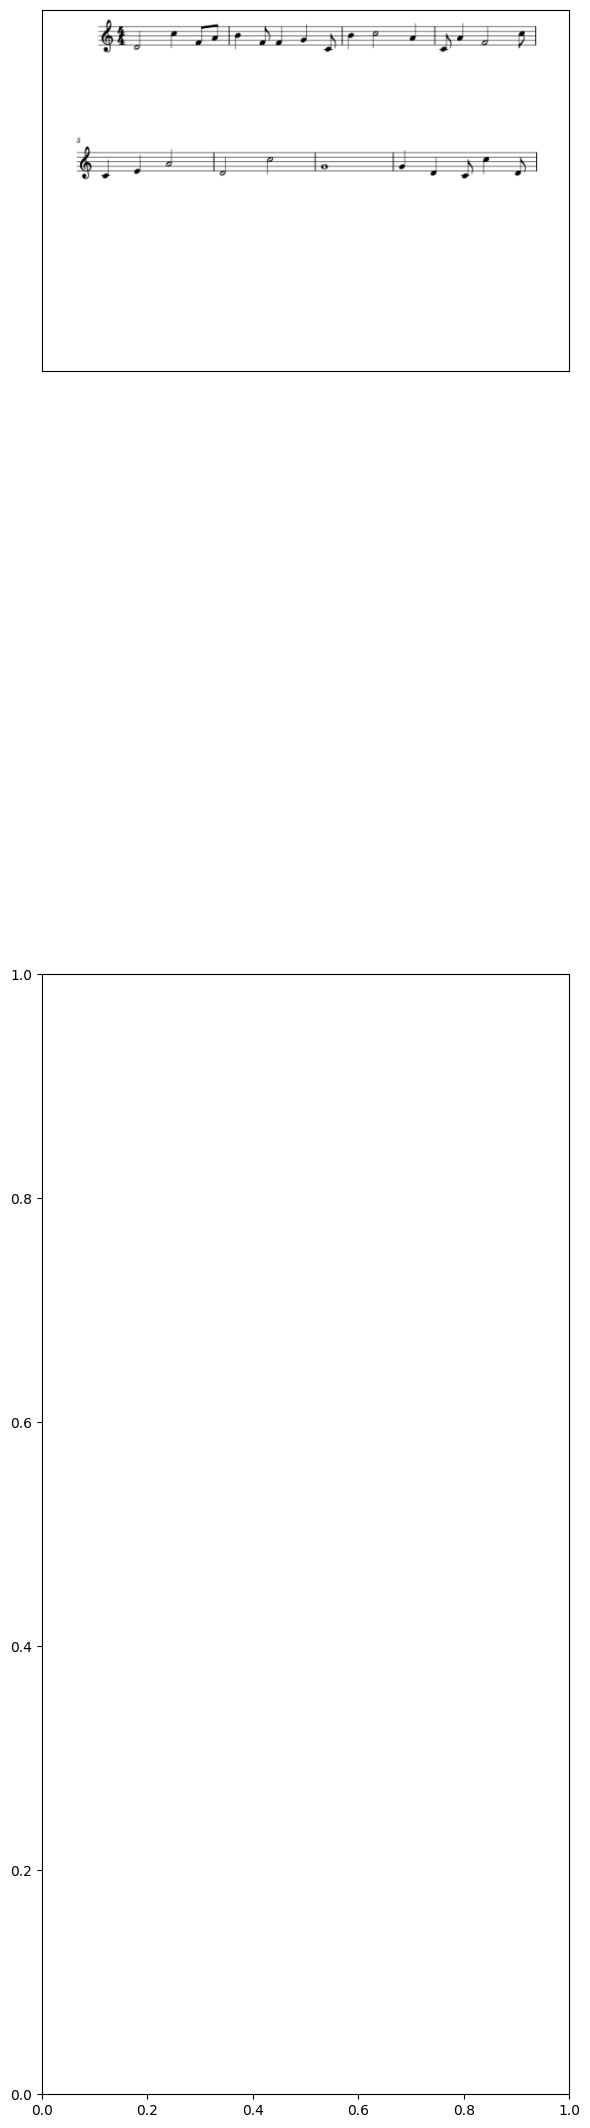

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

image_transform = transforms.Compose([
    transforms.Resize((HEIGHT, WIDTH)),
    transforms.RandomAffine(degrees=0, shear=2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


dataset = MusicImageDataset(image_root, midi_root, image_transform, max_midi_files=24, modify_image=False)
val_dataset = MusicImageDataset(image_root_test, midi_root_test, image_transform, max_midi_files=8, modify_image=False)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset, shuffle=False, num_workers=8, pin_memory=True)

cae = AE()
epochs = epochs

params_to_optimize = [
    {'params': cae.parameters()}
]

loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=1e-05)
cae.to(device)

best_val_loss = 1000000
best_epoch = 0
#Training loop
t1 = datetime.datetime.now()
print("Start training..")
for epoch in range(epochs):
    print('> Epoch ' + str(epoch + 1))
    train_loss = train_epoch(cae, device, dataloader, loss_fn, optim)
    print("Evaluating on test set...")
    val_loss = test_epoch(cae,device, val_dataloader, loss_fn)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}.'.format(epoch + 1, epochs, train_loss, val_loss))
    print('Plotting results...')
    # plot_ae_outputs(cae, "train_dataset", epoch, dataset, device,n=5)
    plot_ae_outputs(cae, "test_dataset", epoch, val_dataset, device,n=8)
    if val_loss <= best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            checkpoint(cae, best_epoch, best_val_loss, MODEL_FILENAME)
    elif epoch - best_epoch > early_stopping:
        print(f"Early stopped training at epoch {epoch}")
        model, _, _ = resume(cae, MODEL_FILENAME)
        break  # terminate the training loop
print("Total training time:",datetime.datetime.now()-t1)